In [1]:
!pip install chardet
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 2.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 2.6 MB/s eta 0:00:0000:0100:01


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import chardet
import math
from statistics import mode

In [5]:
# Chargement de toutes les données
file_imp_path = "data/database-imputed ESG.xlsx"
file_raw_path = "data/database raw ESG.xlsx"
file_sup_path = "data/correct_gender_gap.xlsx"
imp_data = pd.read_excel(file_imp_path)
raw_data = pd.read_excel(file_raw_path)
sup_data = pd.read_excel(file_sup_path)

In [8]:
# Variables disponibles
variables = ["market_cap", "employees", "revenue", "scope_1", "scope_2", "scope_3",
                         "waste_production", "waste_recycling", "water_consumption",
                         "water_withdrawal", "energy_consumption", "hours_of_training",
                         "gender_pay_gap", "independent_board_members_percentage",
                         "legal_costs_paid_for_controversies", "ceo_compensation"]

variables_env = ["scope_1", "scope_2", "scope_3",
                "waste_production", "waste_recycling", "water_consumption",
                "water_withdrawal", "energy_consumption"]

variables_eg = ["hours_of_training","gender_pay_gap", "independent_board_members_percentage",
                "legal_costs_paid_for_controversies", "ceo_compensation"]

# Années 
annees = ["2018", "2019", "2020"]

# Regions 
regions = ["Africa / Middle East", "Asia / Pacific", "Europe", 
           "Latin America and Caribbean", "United States and Canada"]

# Secteurs 
secteurs = imp_data['primary_industry'].unique()

In [29]:
all_r2 = []
count = 0

#for x in variables_env, y in variables_eg, a in annees, r in regions, s in secteurs :
for x in variables_env :
    for y in variables_eg :
        for a in ["2020"] :
            for r in ["Europe"] :
                for s in secteurs :
                    count+= 1
                    data = pd.DataFrame(imp_data[(imp_data["year"] == int(a)) & (imp_data["primary_industry"] == s) & (imp_data["region"] == r)])
                    if data[x].size > 5 and data[y].size > 5 :
                        slope, intercept, r_value, p_value, std_err = linregress(data[x], data[y])
                        r_squared = r_value ** 2
                        all_r2.append([r_squared, s])
print(count)

6160


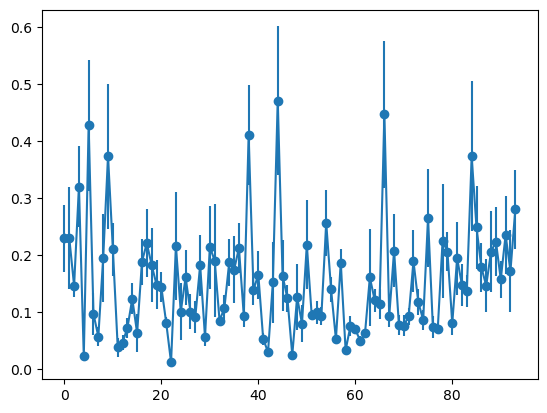

In [60]:
tri_secteurs = []

all_r2 = np.array(all_r2)

for s in secteurs :
    filtre = np.array(all_r2[all_r2[:, 1] == s][:,0], dtype = float)
    if filtre.size != 0 :
        min = np.min(filtre)
        mean = np.mean(filtre)
        max = np.max(filtre)
        err = np.var(filtre)
        tri_secteurs.append([mean, min, max, err, s])

tri_secteurs = np.array(tri_secteurs)
x = np.arange(len(tri_secteurs))
y = np.array(tri_secteurs[:,0], dtype = float)

plt.scatter(x, y)

y_err = np.array(tri_secteurs[:,3], dtype=float)
plt.errorbar(x, y, yerr = y_err)

plt.show()